In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from gwbench import Network, injections_CBC_params_redshift
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles

## Get injection data SNRs

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'CE4020ET123_CoBA10_SNR_3_pop_PLP_spin_aligned_fref_5_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'LHI_SNR_3_pop_PLP_spin_aligned_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [4]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [5]:
pd.DataFrame(inj_data['results'])

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin1z,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,89.081424,57.270932,18.387193,14.800440,10.186230,...,-0.061128,0.0,0.0,0.126310,7.140745,6.850547,6.088491,13.991292,1401.516982,1.893025e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,5.955440,4.285237,11.389722,8.947595,10.628861,...,0.406850,0.0,0.0,0.114056,7.725840,5.403342,5.606829,13.129181,1051.424937,1.893026e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,26.147823,19.659339,9.576124,11.215747,9.800301,...,0.190466,0.0,0.0,0.135335,9.001862,6.051958,6.400407,15.053820,1476.593981,1.893028e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,18.312133,8.410959,11.706618,11.557690,11.564004,...,0.078424,0.0,0.0,0.051417,7.757496,3.677842,4.587108,11.435338,255.032633,1.893028e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,118.750050,48.394232,48.624391,52.568369,59.959634,...,-0.002809,0.0,0.0,0.016454,9.604591,9.163552,8.166602,18.768143,726.809460,1.893029e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31723,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,143.715625,85.026031,27.309742,17.701951,22.978051,...,-0.106414,0.0,0.0,-0.383791,11.843026,11.747124,10.268108,23.590151,740.015986,1.924564e+09
31724,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,27.652694,27.344690,33.924644,35.764627,22.748134,...,-0.011413,0.0,0.0,0.065236,24.015931,15.653630,16.802628,39.669561,2680.661719,1.924566e+09
31725,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,44.165223,30.338099,15.876198,13.373911,8.137935,...,-0.174605,0.0,0.0,-0.286785,24.025652,21.389956,19.728316,45.415608,1494.141073,1.924568e+09
31726,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,25.082589,11.767914,2.780939,4.864452,4.881824,...,0.002227,0.0,0.0,0.365035,11.909734,3.737950,5.626409,15.647684,1654.495984,1.924570e+09


### Calculate MF SNRs from Optimal SNRs

In [24]:
def mf_snr_from_opt_snr(opt_snr, method='chisq'):
    """
    Choose method from ['chisq', 'normal']
    """
    if method == 'normal':
        mf_snr = np.random.normal(loc=opt_snr, scale=1.0)
    elif method == 'chisq':
        mf_snr_sq = ncx2.rvs(2, opt_snr**2)
        mf_snr = np.sqrt(mf_snr_sq)
    return(mf_snr)

In [7]:
#dets = ['L1', 'H1', 'I1']
dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
for det in dets:
    inj_data['results'][f'SNR_mf_from_opt_{det}'] = []
inj_data['results']['SNR_mf_from_opt_network'] = []

for event in tqdm(range(len(inj_data['results']['SNR_network']))):
    snr_netw_sq = 0
    for det in dets:
        snr_det = mf_snr_from_opt_snr(inj_data['results'][f'SNR_{det}'][event])
        inj_data['results'][f'SNR_mf_from_opt_{det}'].append(snr_det)
        snr_netw_sq += snr_det**2
    inj_data['results']['SNR_mf_from_opt_network'].append(np.sqrt(snr_netw_sq))

for key in inj_data['results'].keys():
    if 'mf_from_opt' in key:
        inj_data['results'][key] = np.array(inj_data['results'][key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31728/31728 [00:05<00:00, 6296.83it/s]


### Get detected

In [6]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

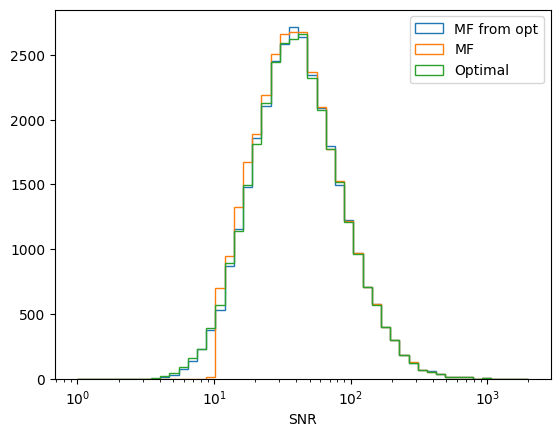

In [7]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.hist(inj_data['results']['SNR_mf_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF');
plt.hist(inj_data['results']['SNR_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='Optimal');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

In [8]:
inj_data['detected_mf_from_opt'] = get_detected_SNRs(inj_data['results'], method='two-detector', 
                                                     snr_type='mf_from_opt', network_threshold=10)

['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


### Detected percentage

In [9]:
n_total = len(inj_data['results']['redshift'])
n_detected = len(inj_data['detected_mf_from_opt']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 31728
detected = 30590 = 96.4 %


### Choose n_events from detected as injection parameters

In [10]:
n_events = 5767
#n_events = len(inj_data['detected_mf_from_opt']['redshift'])
inj_data['selected_n_events'] = inj_data['detected_mf_from_opt'].sample(n_events, 
                                                                        random_state=123).reset_index().rename(columns={'index': 'old_index'})
#inj_data['selected_n_events'] = inj_data['detected_mf'].iloc[:n_events]

Text(0.5, 0, 'z')

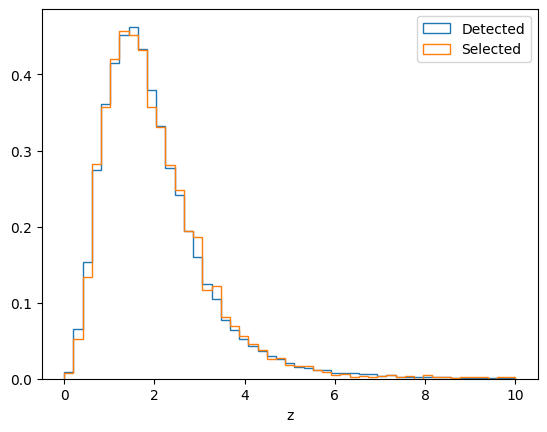

In [11]:
plt.hist(inj_data['detected_mf_from_opt']['redshift'], density=True, histtype=u'step', bins=np.linspace(0,10,50), 
         label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', 
         bins=np.linspace(0,10,50), label='Selected');
plt.legend()
plt.xlabel('z')

In [12]:
len(inj_data['selected_n_events']['redshift'])

5767

## FM analysis with GWBench

### Setup - A#

In [49]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, f_low, f_ref, f_high, df, logging_level='WARNING', num_cores=4):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXPHM', 'fRef':f_ref}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True}}
    user_locs = {'I1':{'longitude': 1.34444215058, 'latitude':0.34231676739, 'arm_azimuth':2.0527812170378947, 
                       'which_arm':'x', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['A-Sharp_L', 'A-Sharp_H', 'A-Sharp_I1']
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds, 
                     user_locs=user_locs)
    net.calc_errors(derivs='num', f_lo=f_low, f_hi=f_high, num_cores=num_cores)
    return(net.fisher, net.cov, net.errs, net.snr, net.deriv_variables, net.inv_err['inv_err'])

### Setup - CE4020ET123

In [13]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, f_low, f_ref, f_high, df, logging_level='WARNING', num_cores=4):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXPHM', 'fRef':f_ref}
    user_psds = {'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/ET10_CoBA-psd.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'},
                 'CE20':{'longitude': -1.6406094969, 'latitude': 0.5061454831, 'arm_azimuth':2*np.pi-5.0614548308, 'which_arm':'y', 
                         'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['CE40_C1', 'CE20_CE20', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_errors(derivs='num', f_lo=f_low, f_hi=f_high, num_cores=num_cores)
    return(net.fisher, net.cov, net.errs, net.snr, net.deriv_variables, net.inv_err['inv_err'])

### Calculate Errors

In [14]:
gwbench_to_pycbc_map = {
    'Mc': 'mchirp',
    'eta': 'eta',
    'DL': 'distance',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'polarization',
    'chi1z': 'spin1z',
    'chi2z': 'spin2z',
    'tc': 'trigger_time',
    'phic': 'coa_phase'
}

In [15]:
inj_data['selected_n_events']

,old_index,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,...,spin1z,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,time_interval,trigger_time
0,18747,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,55.536776,26.677202,15.647321,16.002680,...,0.076150,0.0,0.0,0.176487,11.092899,7.050880,7.659977,18.143779,302.563764,1.911635e+09
1,14008,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,54.159732,36.144803,14.760381,14.351107,...,0.041180,0.0,0.0,-0.124308,7.027979,2.923010,3.872784,9.950989,368.525422,1.906809e+09
2,5367,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,50.810638,34.005549,26.424110,25.734856,...,-0.112430,0.0,0.0,-0.027157,18.598281,8.674058,10.901157,27.272338,610.009607,1.898345e+09
3,23820,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,27.618614,13.773625,2.115510,2.105184,...,-0.030078,0.0,0.0,-0.162919,8.670643,8.316515,7.392162,16.987158,581.171725,1.916626e+09
4,27103,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,68.416139,41.223552,14.798247,10.495220,...,0.062304,0.0,0.0,0.027510,37.684345,22.969585,25.457555,60.653930,440.834127,1.919923e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,21401,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,15.405418,11.952305,8.899733,9.718894,...,-0.202505,0.0,0.0,0.035886,10.789628,8.542745,8.346517,19.332372,297.672398,1.914283e+09
5763,28613,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,168.126078,100.121266,32.767760,21.057347,...,-0.197487,0.0,0.0,0.241799,26.718398,22.355951,21.259411,49.074348,1339.356209,1.921463e+09
5764,9187,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,12.747861,7.515708,5.151507,3.869604,...,-0.003616,0.0,0.0,-0.005440,8.743461,5.364918,5.927239,14.108379,1082.951400,1.902111e+09
5765,12201,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,22.308514,26.885689,9.822204,8.219548,...,0.217484,0.0,0.0,0.154004,34.740952,24.486457,25.313724,59.227408,1011.536184,1.904952e+09


In [16]:
inj_data['selected_n_events'].keys()

Index(['old_index', 'PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3',
       'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1',
       'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3',
       'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1',
       'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network',
       'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1',
       'chi_1_in_plane', 'chi_2', 'chi_2_in_plane', 'chi_eff', 'chi_p',
       'coa_phase', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower',
       'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal',
       'polarization', 'q', 'ra', 'redshift', 'spin1x', 'spin1y', 'spin1z',
       'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp',
       'srcmtotal', 'time_interval', 'trigger_time'],
      dtype='object')

In [17]:
inj_records = inj_data['selected_n_events'].to_records()
results = {'inj_params':[], 'cov':[], 'errs':[]}
failed_events = {'inj_params':[], 'event_num':[]}
#for event_num in tqdm(range(3)):
for event_num in tqdm(range(len(inj_records))):
    params_i = inj_records[event_num]
    inj_params = {'chi1x': params_i['spin1x'], 
                  'chi1y': params_i['spin1y'],
                  'chi2x': params_i['spin2x'],
                  'chi2y': params_i['spin2y'],
                  'chi1z': params_i['spin1z'],
                  'chi2z': params_i['spin2z']}
    for param in fm_params_str.split():
        if param == 'iota':
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2 =  spin_angles(params_i['mass1'], params_i['mass2'], 
                                                                              params_i['inclination'], 
                                                                              params_i['spin1x'], params_i['spin1y'], params_i['spin1z'], 
                                                                              params_i['spin2x'], params_i['spin2y'], params_i['spin2z'], 
                                                                              params_i['f_ref'], params_i['coa_phase'])
            inj_params[param] = theta_jn
        else:
            inj_params[param] = params_i[gwbench_to_pycbc_map[param]]
    try:
        fm, cov, errs, snr, deriv_vars, inv_err = run_analysis(inj_params, 
                                                               params_i['f_lower'], 
                                                               params_i['f_ref'],
                                                               params_i['f_final'],
                                                               1/16,
                                                               num_cores=8)
        results['inj_params'].append(inj_params)
        errs['snr'] = snr
        errs['inv_err'] = inv_err
        results['cov'].append(cov)
        results['errs'].append(errs)
        results['deriv_variables_in_order'] = deriv_vars
    except:
        failed_events['event_num'].append(event_num)
        failed_events['inj_params'].append(inj_params)

2025-09-16 21:42:31,870 - Network - WARNING : calc_cov_inv_err: tag = ET10-CoBA_ET2 - There was an exception in the inversion of the Fisher matrix! 4487/5767 [2:31:14<35:11,  1.65s/it]
2025-09-16 21:42:31,910 - Network - WARNING : calc_sky_area_90_network: tag = ET10-CoBA_ET2 - 90%-credible sky area not calculated due to None-valued cov or errs.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5767/5767 [3:09:19<00:00,  1.97s/it]


In [19]:
failed_events

{'inj_params': [], 'event_num': []}

In [20]:
len(inj_records)

5767

In [21]:
results['all_inj_params_original'] = []
for event_num in range(len(inj_records)):
    if event_num in failed_events['event_num']:
        print(f'Skipped event_num = {event_num}')
        continue
    params_i = inj_records[event_num]
    results['all_inj_params_original'].append({key:params_i[key] for key in params_i.dtype.names})

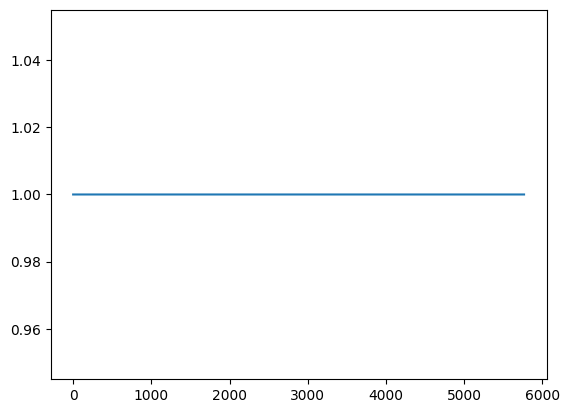

In [22]:
plt.plot(pd.DataFrame(results['inj_params'])['DL']/pd.DataFrame(results['all_inj_params_original'])['distance'])

### Check if cov matrices are positive-definite

In [23]:
failed = []
for event in range(len(results['all_inj_params_original'])):
    cov = results['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [24]:
failed

[]

In [25]:
failed_dict = {}
if len(failed) !=0:
    failed_dict['inj_params'] = pd.DataFrame([results['inj_params'][i] for i in failed])
    failed_dict['all_inj_params_original'] = pd.DataFrame([results['all_inj_params_original'][i] for i in failed])

In [26]:
failed_dict['inj_params']

KeyError: 'inj_params'

In [27]:
print(len(results['inj_params']))

5767


In [28]:
results.keys()

dict_keys(['inj_params', 'cov', 'errs', 'deriv_variables_in_order', 'all_inj_params_original'])

In [29]:
results_updated = {}
for key in results.keys():
    if key == 'deriv_variables_in_order':
        results_updated[key] = results[key]
    else:
        if len(failed) == 0:
            print("No failed events")
            results_updated[key] = results[key]
        else:
            results_updated[key] = [results[key][i] for i in range(len(results[key])) if i not in failed]

No failed events
No failed events
No failed events
No failed events


In [30]:
print(len(results_updated['inj_params']))

5767


### Check for positive-definite again

In [31]:
failed2 = []
for event in range(len(results_updated['all_inj_params_original'])):
    cov = results_updated['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed2.append(event)

In [32]:
failed2

[]

### Add redshift to results file

In [33]:
for i, z in enumerate(pd.DataFrame(results['all_inj_params_original'])['redshift']):
    results['inj_params'][i]['z'] = z

In [34]:
for i, z in enumerate(pd.DataFrame(results_updated['all_inj_params_original'])['redshift']):
    results_updated['inj_params'][i]['z'] = z

#### Check the values are fine

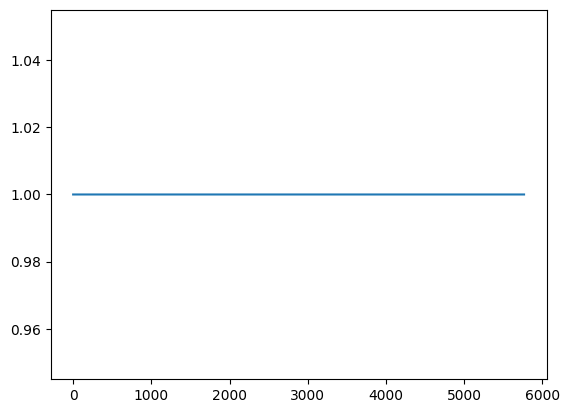

In [35]:
import pycbc.cosmology as cosmo
temp_z = cosmo.redshift(np.array(pd.DataFrame(results_updated['inj_params'])['DL']))
plt.plot(np.around(temp_z/pd.DataFrame(results_updated['inj_params'])['z'], 6))

Text(0.5, 0, '$\\Delta D_L / D_L$')

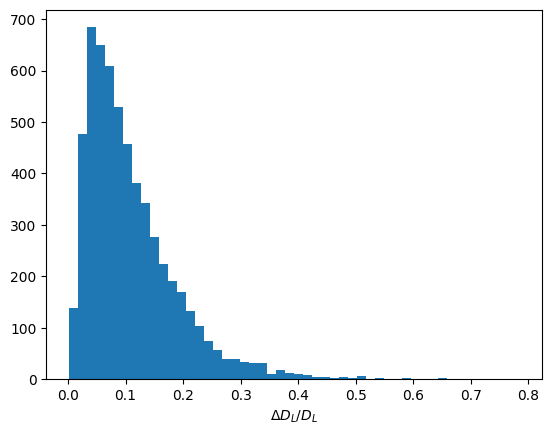

In [36]:
plt.hist([results_updated['errs'][i]['log_DL'] for i in range(len(results_updated['errs']))], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

### Load results from file for plotting (if needed)

In [19]:
def load_results_from_h5(filename):
    results = {}

    with h5py.File(filename, 'r') as f:
        # Load inj_params
        inj_params = []
        inj_params_group = f['inj_params']
        for i in sorted(inj_params_group.keys(), key=lambda x: int(x)):
            param_group = inj_params_group[i]
            param_dict = {key: param_group[key][()] for key in param_group.keys()}
            inj_params.append(param_dict)
        results['inj_params'] = pd.DataFrame(inj_params)

        # Load cov
        cov = []
        cov_group = f['cov']
        for i in sorted(cov_group.keys(), key=lambda x: int(x)):
            matrix = cov_group[i][()]
            cov.append(matrix)
        results['cov'] = cov

        # Load errs
        errs = []
        errs_group = f['errs']
        for i in sorted(errs_group.keys(), key=lambda x: int(x)):
            err_group = errs_group[i]
            err_dict = {key: err_group[key][()] for key in err_group.keys()}
            errs.append(err_dict)
        results['errs'] = pd.DataFrame(errs)

        # Load deriv_variables_in_order
        deriv_vars = f['deriv_variables_in_order'][()]
        # Convert bytes to str if needed (depends on h5py version)
        if isinstance(deriv_vars[0], bytes):
            deriv_vars = [s.decode('utf-8') for s in deriv_vars]
        results['deriv_variables_in_order'] = list(deriv_vars)

    return results

In [ ]:
try:
    inj_records
    print('inj_records found')
except NameError:
    inj_records = inj_data['selected_n_events'].to_records()
try:
    results
    print('results found')
except NameError:
    base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
    fm_err_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH', 
                               'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins.h5')
    results = load_results_from_h5(fm_err_file)
try:
    failed_events
except NameError:
    failed_events = {'inj_params':[]}

### Don't load results from file

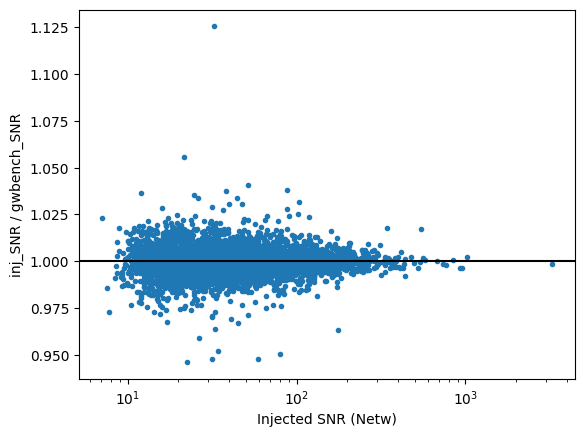

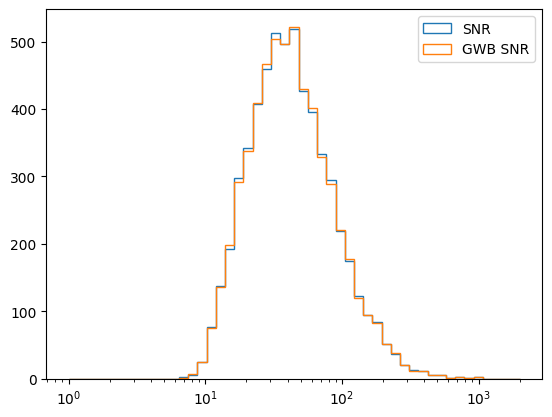

In [37]:
inj_snrs = pd.DataFrame(results_updated['all_inj_params_original'])['SNR_network']
gwbench_snrs = pd.DataFrame(results_updated['errs'])['snr']

plt.figure()
plt.plot(inj_snrs, inj_snrs/gwbench_snrs, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwbench_SNR')
plt.axhline(1, c='k')
plt.xscale('log')

plt.figure()
plt.hist(inj_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='SNR');
plt.hist(gwbench_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='GWB SNR');
plt.legend()
plt.xscale('log')

### Plots for SNR comparison diagnostic

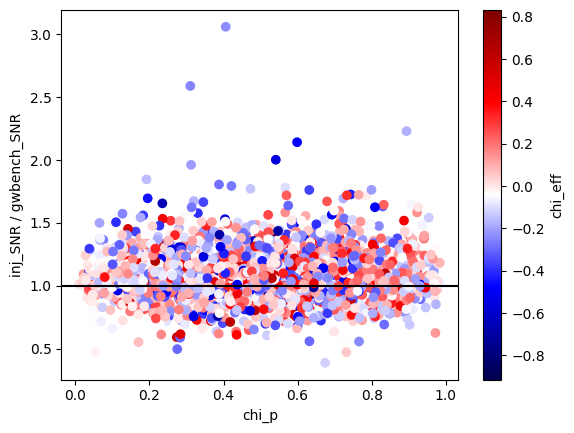

In [73]:
plt.scatter(pd.DataFrame(results_updated['all_inj_params_original'])['chi_p'], 
         inj_snrs/gwbench_snrs, 
         c=pd.DataFrame(results_updated['all_inj_params_original'])['chi_eff'], cmap='seismic')
plt.xlabel('chi_p')
plt.ylabel('inj_SNR / gwbench_SNR')
plt.axhline(1, c='k')
plt.colorbar(label='chi_eff')
#plt.xscale('log')

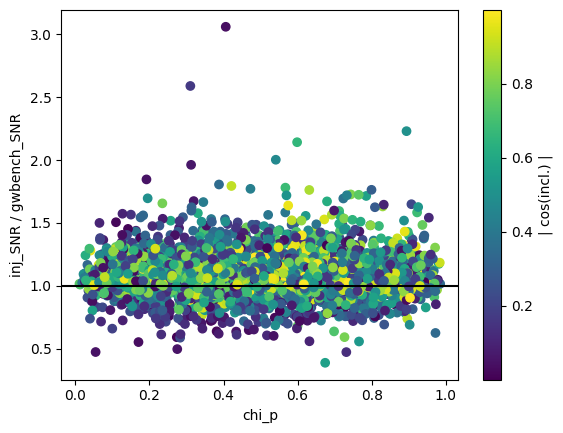

In [74]:
plt.scatter(pd.DataFrame(results_updated['all_inj_params_original'])['chi_p'], 
         inj_snrs/gwbench_snrs, 
         c=np.abs(np.cos(pd.DataFrame(results_updated['all_inj_params_original'])['inclination'])), cmap='viridis')
plt.xlabel('chi_p')
plt.ylabel('inj_SNR / gwbench_SNR')
plt.axhline(1, c='k')
plt.colorbar(label='| cos(incl.) |')
#plt.xscale('log')

In [75]:
high_snr_ratio_select = (inj_snrs/gwbench_snrs > 2)

In [77]:
pd.concat([pd.DataFrame(results_updated['inj_params']), pd.DataFrame(results_updated['errs'])[['snr']]], axis=1)[high_snr_ratio_select]

,chi1x,chi1y,chi2x,chi2y,chi1z,chi2z,Mc,eta,DL,iota,tc,phic,ra,dec,psi,z,snr
1823,-0.551600,0.232771,0.042913,0.152369,-0.673949,0.035545,88.441791,0.196802,15100.637994,2.665700,1.919549e+09,2.625780,3.395161,0.501768,0.047037,1.913918,36.056339
3418,0.374640,-0.156647,0.386102,-0.092728,-0.292323,-0.177880,166.726048,0.248946,40683.575494,1.289955,1.912790e+09,1.980827,3.526588,-0.383497,1.968635,4.364672,11.378489
3697,-0.086249,-0.534269,-0.273410,-0.671911,-0.753637,-0.178885,80.405639,0.226960,16956.234674,0.659091,1.916629e+09,3.085365,0.855367,0.723096,0.843103,2.104523,50.568618
3824,0.022337,-0.074077,0.467484,0.062954,-0.033114,-0.564357,266.421764,0.241793,30084.416929,1.284080,1.912555e+09,2.058843,3.047091,-0.976543,0.338511,3.384546,27.259973
4095,0.757292,-0.475168,-0.273130,-0.152753,-0.373757,0.131095,70.958326,0.239990,25003.176250,0.793548,1.916432e+09,1.785835,0.187935,1.182698,2.202768,2.900328,29.587607


In [78]:
pd.DataFrame(results_updated['all_inj_params_original'])[high_snr_ratio_select][['chi_eff', 'chi_p', 'mchirp', 'eta', 'distance', 'inclination', 'ra', 'dec', 'polarization', 'redshift', 'SNR_network', 'trigger_time']]

,chi_eff,chi_p,mchirp,eta,distance,inclination,ra,dec,polarization,redshift,SNR_network,trigger_time
1823,-0.482845,0.598703,88.441791,0.196802,15100.637994,2.288945,3.395161,0.501768,0.047037,1.913918,77.230755,1.919549e+09
3418,-0.238816,0.406071,166.726048,0.248946,40683.575494,1.535324,3.526588,-0.383497,1.968635,4.364672,34.809165,1.912790e+09
3697,-0.553502,0.541186,80.405639,0.226960,16956.234674,1.080492,0.855367,0.723096,0.843103,2.104523,101.264834,1.916629e+09
3824,-0.250609,0.310493,266.421764,0.241793,30084.416929,1.403366,3.047091,-0.976543,0.338511,3.384546,70.572473,1.912555e+09
4095,-0.171841,0.894022,70.958326,0.239990,25003.176250,1.044693,0.187935,1.182698,2.202768,2.900328,65.971299,1.916432e+09


## Save to h5 file

In [38]:
def save_to_h5_group(group, data, string_dtype):
    """
    Recursively saves Python data structures (dicts, lists, arrays, scalars) to an HDF5 group.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            sub_key = str(key)
            if isinstance(value, (dict, list, tuple)):
                subgroup = group.create_group(sub_key)
                save_to_h5_group(subgroup, value, string_dtype)
            elif isinstance(value, str):
                group.create_dataset(sub_key, data=value, dtype=string_dtype)
            else:
                group.create_dataset(sub_key, data=np.array(value))
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            item_key = str(i)
            if isinstance(item, (dict, list, tuple)):
                subgroup = group.create_group(item_key)
                save_to_h5_group(subgroup, item, string_dtype)
            elif isinstance(item, str):
                group.create_dataset(item_key, data=item, dtype=string_dtype)
            else:
                group.create_dataset(item_key, data=np.array(item))
    elif isinstance(data, str):
        group.create_dataset("value", data=data, dtype=string_dtype)
    else:
        group.create_dataset("value", data=np.array(data))


def save_results_to_h5(results, filename):
    """
    Saves arbitrary nested results dictionary to an HDF5 file.
    """
    dt = h5py.string_dtype(encoding='utf-8')
    with h5py.File(filename, 'w') as f:
        save_to_h5_group(f, results, dt)

In [39]:
def save_results_to_h5(results, filename):
    with h5py.File(filename, 'w') as f:
        # Save inj_params
        inj_params_group = f.create_group('inj_params')
        for i, param_dict in enumerate(results['inj_params']):
            param_group = inj_params_group.create_group(str(i))
            for key, value in param_dict.items():
                param_group.create_dataset(key, data=value)

        # Save cov (numpy matrices)
        cov_group = f.create_group('cov')
        for i, matrix in enumerate(results['cov']):
            cov_group.create_dataset(str(i), data=matrix)

        # Save errs
        errs_group = f.create_group('errs')
        for i, err_dict in enumerate(results['errs']):
            err_group = errs_group.create_group(str(i))
            for key, value in err_dict.items():
                err_group.create_dataset(key, data=value)

        all_inj_original_group = f.create_group('all_inj_params_original')
        for i, param_dict in enumerate(results['all_inj_params_original']):
            param_group = all_inj_original_group.create_group(str(i))
            for key, value in param_dict.items():
                if 'PSD' in key or key == 'approximant':
                    continue
                param_group.create_dataset(key, data=value)

        # Save deriv_variables_in_order (list of strings)
        dt = h5py.string_dtype(encoding='utf-8')
        f.create_dataset('deriv_variables_in_order', 
                         data=np.array(results['deriv_variables_in_order'], 
                                       dtype=dt))

### With debug

In [129]:
def save_results_to_h5_with_debug(results, filename):
    with h5py.File(filename, 'w') as f:
        # Save inj_params
        inj_params_group = f.create_group('inj_params')
        for i, param_dict in enumerate(results['inj_params']):
            param_group = inj_params_group.create_group(str(i))
            for key, value in param_dict.items():
                if value is not None:
                    try:
                        param_group.create_dataset(key, data=value)
                    except Exception as e:
                        print(f"[inj_params][{i}][{key}] - Error creating dataset: {e}")
                else:
                    print(f"[inj_params][{i}][{key}] is None")

        # Save cov
        cov_group = f.create_group('cov')
        for i, matrix in enumerate(results['cov']):
            if matrix is not None:
                try:
                    cov_group.create_dataset(str(i), data=matrix)
                except Exception as e:
                    print(f"[cov][{i}] - Error creating dataset: {e}")
            else:
                print(f"[cov][{i}] is None")

        # Save errs
        errs_group = f.create_group('errs')
        for i, err_dict in enumerate(results['errs']):
            err_group = errs_group.create_group(str(i))
            for key, value in err_dict.items():
                if value is not None:
                    try:
                        err_group.create_dataset(key, data=value)
                    except Exception as e:
                        print(f"[errs][{i}][{key}] - Error creating dataset: {e}")
                else:
                    print(f"[errs][{i}][{key}] is None")

        # Save all_inj_params_original
        all_inj_original_group = f.create_group('all_inj_params_original')
        for i, param_dict in enumerate(results['all_inj_params_original']):
            param_group = all_inj_original_group.create_group(str(i))
            for key, value in param_dict.items():
                if value is not None:
                    try:
                        param_group.create_dataset(key, data=value)
                    except Exception as e:
                        print(f"[all_inj_params_original][{i}][{key}] - Error creating dataset: {e}")
                else:
                    print(f"[all_inj_params_original][{i}][{key}] is None")

        # Save deriv_variables_in_order
        try:
            dt = h5py.string_dtype(encoding='utf-8')
            f.create_dataset('deriv_variables_in_order', 
                             data=np.array(results['deriv_variables_in_order'], dtype=dt))
        except Exception as e:
            print(f"[deriv_variables_in_order] - Error creating dataset: {e}")

### Write to file

In [40]:
len(results_updated['inj_params'])

5767

In [41]:
results_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH',
                            f'CE4020ET123_CoBA10_3_PLP_z_MD_zmax_10_lmrd_22_spins_in_FM_inj_{len(results_updated["inj_params"])}_events_pop_from_XPHM_det10.h5')
#results_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH',
#                            'LHI_Asharp_3_PLP_z_MD_zmax_10_lmrd_22_spins_in_FM_inj_all_events_365_days_pop_from_XPHM_det10.h5')
save_results_to_h5(results_updated, results_file)

## Spot checks with MPSAC study

In [95]:
mpsac_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/Relevant_papers/Ish Gupta_et_al_data/'
mpsac_data_bbh = {}
with h5py.File(glob(os.path.join(mpsac_dir, '*', '*', '*bbh*hdf5'))[0], 'r') as file:
    i=9
    inj_params = {key:file['inj_params'][key][i] for key in file['inj_params'].keys()}
    Mc = (1+inj_params['z'])*inj_params['Mc']
    inj_params['Mc'] = Mc
    print(inj_params)
    fm, cov, errs, snr, dvars, inv_errs = run_analysis(inj_params)
    err_dict = {key:[file['networks']['HLI'][key][i], errs[key]] for key in errs.keys()}
    try:
        np.linalg.cholesky(cov)
    except Exception as e:
        print('\n', 'Error:', e)
    err_dict['source'] = ['MPSAC', 'Current analysis']
    err_df = pd.DataFrame(err_dict).set_index('source').T

{'DL': np.float64(613.0532129566052), 'Mc': np.float64(29.52608930472442), 'chi1x': np.float64(0.0), 'chi1y': np.float64(0.0), 'chi1z': np.float64(0.09757743535542235), 'chi2x': np.float64(0.0), 'chi2y': np.float64(0.0), 'chi2z': np.float64(0.13015506724064474), 'dec': np.float64(0.6005676332161993), 'eta': np.float64(0.2480576947053691), 'gmst0': np.float64(44958.217426017385), 'iota': np.float64(0.9661358753614275), 'log_DL': np.float64(6.418451739601951), 'log_Mc': np.float64(3.266043329076431), 'phic': np.float64(0.0), 'psi': np.float64(1.9138262503804069), 'ra': np.float64(1.0558372118915251), 'tc': np.float64(0.0), 'z': np.float64(0.12663005714874154)}

 Error: Matrix is not positive definite


In [96]:
err_df

source,MPSAC,Current analysis
log_Mc,0.000149,0.000226
eta,0.000487,0.000449
log_DL,0.030009,0.040938
iota,0.029717,0.046089
tc,0.000031,0.000043
phic,0.108621,0.108604
ra,0.001964,0.001815
dec,0.001257,0.002764
psi,0.031062,0.045767
chi1z,0.006382,0.002605
